In [1]:
import os
import sys
import shutil
import time
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import cv2
from matplotlib import cm

In [2]:
sys.path.append("../python/")
from helpers import *
from analyze_predictions_new_gradcam import generateGradcam, renderGradcam

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [3]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [4]:
RESOLUTION_LIST = [336]
TILE_SIZE = 38
LOC = 10
SCENARIO_LIST = ["PrPo_Im"]
AUGMENTATION = 'fliplr'
RP_MODEL_PATH = '../../results/rp/models/opt-cnn-base-PrPo_Im-w-336-px-h-336-px/model'
CD_MODEL_PATH = '../../results/cd/models/conf-det-test-inception_v3--w-336-px-h-336-px/model'
VIS_INDEX_PATH = '../../results/vis/index/tp_index.csv'

In [5]:
source_directory = '../../data/vis/input/tiles/'
destination_directory = '../../data/vis/input/test/non_processed'
dest_processed = '../../data/vis/input/test/processed/'

In [6]:
cd_model = models.load_model(CD_MODEL_PATH)
rp_model = models.load_model(RP_MODEL_PATH)
vis_index = pd.read_csv(VIS_INDEX_PATH)
# Edit the preprocessed_index column to exclude 'test-'
vis_index['preprocessed_index'] = vis_index['preprocessed_index'].str.replace('test-', '')
vis_index['labeled_image'] = vis_index['labeled_image'].str.rstrip('.jpg')

### Risk Prediction Images & Labels

In [7]:
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='train', rectangular = False, testing=False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='test', rectangular = False, testing=False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [8]:
class_labels = getClassLabels(SCENARIO_LIST[0])
training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[RESOLUTION_LIST[0]][SCENARIO_LIST[0]])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[RESOLUTION_LIST[0]][SCENARIO_LIST[0]])

In [9]:
rp_predictions = rp_model.predict(np.squeeze(test_images))

In [10]:
vis_index

,labeled_image,preprocessed_index
0,possible-104,106
1,possible-107,107
2,possible-118,109
3,possible-12,110
4,possible-121,111
...,...,...
59,probable-63,166
60,probable-68,167
61,probable-71,168
62,probable-86,169


In [26]:
print(vis_index.iloc[LOC])
labeled_image = vis_index.iloc[LOC].values[0]
preprocessed_index = int(vis_index.iloc[LOC].values[1])

labeled_image         possible-148
preprocessed_index             117
Name: 10, dtype: object


In [12]:
def plotGradCAM(activation_map, image):
    plt.figure(figsize=(8, 8))
    plt.tight_layout()
    
    # Normalize the activation map to [0, 1]
    activation_map_normalized = activation_map / activation_map.max()

    # Convert the activation map to RGB using the 'jet' colormap
    heatmap = np.uint8(cm.jet(activation_map_normalized[0])[..., :3] * 255)

    # Plot the resized image
    plt.imshow(np.squeeze(image), cmap='gray')  # Assuming the input image is grayscale, adjust the cmap accordingly

    # Overlay the heatmap on the image
    plt.imshow(heatmap, alpha=0.5)

    plt.axis('off')
    print("Shape of gradcam: ", activation_map.shape)
    print("Shape of image: ", image.shape)
    plt.show()

In [13]:
def returnGCAMheatmap(gcam, alpha_val=1):
    plt.figure(figsize=(8, 8))
    plt.tight_layout()
    
    # Normalize the activation map to [0, 1]
    activation_map_normalized = gcam / gcam.max()
        
    # Convert the activation map to RGB using the 'jet' colormap
    heatmap = np.uint8(cm.jet(activation_map_normalized[0])[..., :3] * 255)
    
    # Overlay the heatmap on the image
    plt.imshow(heatmap, alpha=alpha_val)
    
    plt.axis('off')

In [14]:
# Function to convert the image array into a grid of tiles
def convert_to_grid(image_array, tile_size=38, is_gradcam=True):
    if is_gradcam:
        ax = 0
    else:
        ax = -1
    # Convert RGB image to grayscale
    grayscale_image = np.mean(image_array, axis=ax)
    # print(grayscale_image.shape)
    height, width = grayscale_image.shape[:2]
    grid_size_h = height // tile_size
    grid_size_w = width // tile_size
    tiles = np.zeros((grid_size_h, grid_size_w, tile_size, tile_size))

    for i in range(grid_size_h):
        for j in range(grid_size_w):
            tile = grayscale_image[i * tile_size: (i + 1) * tile_size, j * tile_size: (j + 1) * tile_size]
            # print(tile.shape)
            tiles[i, j] = np.squeeze(tile)

    return tiles

In [15]:
def plot_grid(img_array, tile_size=38, color_map = 'jet', remove_space=True):
    space_arg = {}
    if remove_space:
        space_arg = {'hspace':0, 'wspace': 0}
    # Create the grid plot
    grid_size = img_array.shape[0]
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10), gridspec_kw=space_arg)

    # Plot each tile in the grid
    for i in range(grid_size):
        for j in range(grid_size):
            axs[i, j].imshow(img_array[i, j], cmap=color_map)
            axs[i, j].axis('off')

    plt.show()

### Copy tiles to the destination directory and process them into .npy array

In [16]:
def process_vis_tiles(labeled_image):
    '''Copy tiles to the destination directory and process them into .npy array'''
    # List all files in the source directory
    files = os.listdir(source_directory)

    shutil.rmtree(destination_directory, ignore_errors=True)
    os.makedirs(destination_directory)

    # Iterate through the files in the source directory
    for file in files:
        if file.split('_', 1)[0] == labeled_image:
            # If the file starts with 'possible_121', construct the source and destination paths
            source_file = os.path.join(source_directory, file)
            destination_file = os.path.join(destination_directory, file)

            # Copy the file from the source directory to the destination directory
            shutil.copyfile(source_file, destination_file)

    image_list = os.listdir(destination_directory)
    data_filename = labeled_image + '_draw_predictions.npy'
    processed_data_filepath = os.path.join(dest_processed, data_filename)

    shutil.rmtree(dest_processed, ignore_errors=True)
    os.makedirs(dest_processed)

    data = []
    for image in image_list:
        path = os.path.join(destination_directory, image)
        image = Image.open(path) # read in image
        image = image.resize((336, 336), Image.NEAREST) 
        scaled_image_array = np.array(image)/255.
        data.append([scaled_image_array])

    np.save(processed_data_filepath, data)
    return(processed_data_filepath)

### Calculate VIS score

In [17]:
def calculate_single_vis(rp_data, cd_tiles):
    class_avg = {0: 0,
                 1: 0}
    avg_tile_intensity = []
    results = {}
    # Make predictions on the images using the loaded model
    predictions = cd_model.predict(np.squeeze(rp_data))
    # Interpret the predictions of the two-class classification problem with softmax activation
    class_labels = np.argmax(predictions, axis=1)
    unique_elements, counts = np.unique(class_labels, return_counts=True)
    frequency_dict = dict(zip(unique_elements, counts))
    # If a key doesn't exist, add it with the default value of 0
    if 0 not in frequency_dict:
        frequency_dict.setdefault(0, 0)
    elif 1 not in frequency_dict:
        frequency_dict.setdefault(1, 0)
    print(frequency_dict)
    
    for i in range(0,9):
        for j in range(0,9):
            avg_tile_intensity.append(np.mean(cd_tiles[i][j]))
            
    for c in range(len(class_labels)):
        if class_labels[c] == 0:
            class_avg[0] += avg_tile_intensity[c]
        else:
            class_avg[1] += avg_tile_intensity[c] 
    
    for key in class_avg.keys():
        if frequency_dict[key] != 0:
            results[key] = class_avg[key] / frequency_dict[key]
        else:
            results[key] = 0
            
    print(results)
    vis_score = results[1] - results[0]
    return vis_score

In [27]:
gcam = generateGradcam(rp_model, rp_predictions, preprocessed_index, True)
img_array = test_images[preprocessed_index]

In [28]:
gcam_resized = resize_image_array(gcam, (1, 342, 342))
resized_image_array = resize_image_array(img_array, (342, 342, 1, 3))

Shape of gradcam:  (1, 342, 342)
Shape of image:  (342, 342, 1, 3)


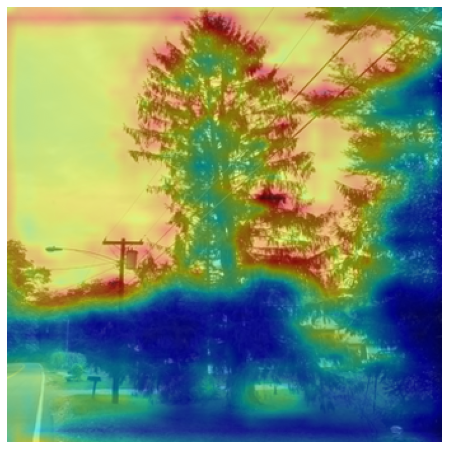

In [29]:
plotGradCAM(gcam_resized, resized_image_array)

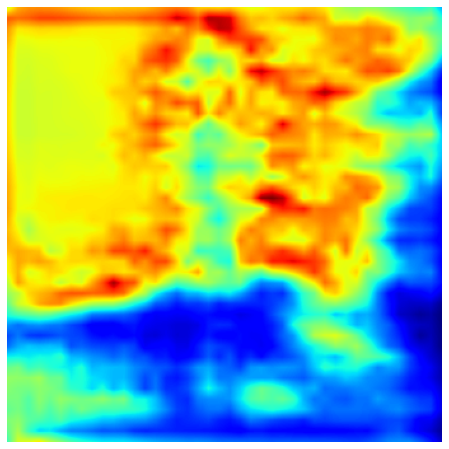

In [30]:
returnGCAMheatmap(gcam_resized)

In [31]:
# Convert the Gradcam array into a grid of tiles
conflict_tiles = convert_to_grid(gcam_resized)

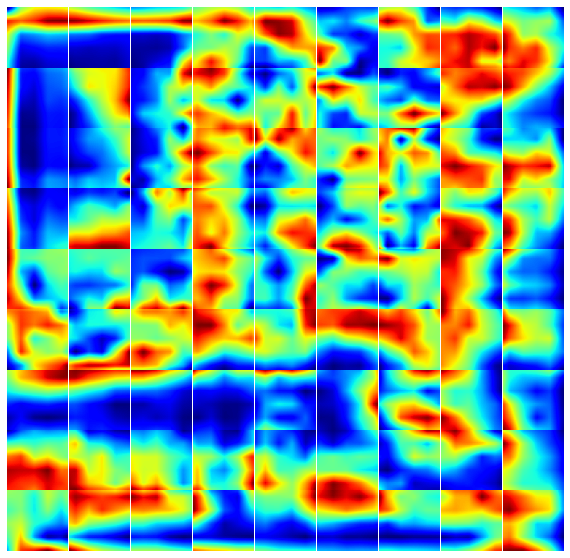

In [32]:
plot_grid(conflict_tiles)

In [33]:
processed_data = process_vis_tiles(labeled_image)
tiles_npy = np.load(processed_data)

In [34]:
calculate_single_vis(tiles_npy, conflict_tiles)

{0: 76, 1: 5}
{0: 0.49238526591930293, 1: 0.7083734568672828}


0.21598819094797989

In [23]:
start = time.time()
rp_model_vis = 0
for i in range(len(vis_index)):
    labeled_image = vis_index.iloc[i].values[0]
    preprocessed_index = int(vis_index.iloc[i].values[1])
    gcam = generateGradcam(rp_model, rp_predictions, preprocessed_index)
    gcam_resized = resize_image_array(gcam, (1, 342, 342))
    # Convert the Gradcam array into a grid of tiles
    conflict_tiles = convert_to_grid(gcam_resized)
    preprocessed_tiles_path = process_vis_tiles(labeled_image)
    tiles_npy = np.load(preprocessed_tiles_path)
    img_vis = calculate_single_vis(tiles_npy, conflict_tiles)
    rp_model_vis += img_vis
network_vis = rp_model_vis / len(vis_index)
print("VIS of risk prediction model is: ", str(network_vis))
elapsed = time.time() - start
print("Calculated network VIS in (h/m/s/ms):", str(timedelta(seconds=elapsed)))

{0: 75, 1: 6}
{0: 0.0016870965452134763, 1: 4.6450497539695695e-23}
{0: 56, 1: 25}
{0: 0.2039354966253624, 1: 0.23983159681565172}
{0: 55, 1: 26}
{0: 0.012542338532965798, 1: 0.02314367933920162}
{0: 80, 1: 1}
{0: 0.26422557458260154, 1: 0.59829120891081}
{0: 74, 1: 7}
{0: 0.19653010356902145, 1: 0.30801524594795443}
{0: 64, 1: 17}
{0: 0.04678022844608727, 1: 0.06196001304722191}
{0: 71, 1: 10}
{0: 0.22719607237150155, 1: 0.49428444893417095}
{0: 67, 1: 14}
{0: 0.36032644051185786, 1: 0.3762785057557712}
{0: 71, 1: 10}
{0: 0.025519645600902488, 1: 0.04986526555548053}
{0: 79, 1: 2}
{0: 0.0021776957826683176, 1: 7.739262258293197e-05}
{0: 76, 1: 5}
{0: 0.0028658522302641115, 1: 2.7863663645408868e-05}
{0: 79, 1: 2}
{0: 0.30104290551069907, 1: 0.6414804034079541}
{0: 67, 1: 14}
{0: 0.0009038874947305541, 1: 1.4730111181774798e-12}
{0: 50, 1: 31}
{0: 0.21537685032140733, 1: 0.3604198850698359}
{0: 53, 1: 28}
{0: 0.028640791359481648, 1: 0.06135987186631468}
{0: 70, 1: 11}
{0: 0.0096599699